# Target Gaps: 2030 emission targets

Here we use the OpenClimate database to compare the aggregate of subnational emission targets to the national determined contribution (NDC).

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import math
import numpy as np
import openclimate as oc
import pandas as pd

In [2]:
from utils import actor_parts, get_target, get_emissions, ipcc_range, linear_equation, scaled_emissions

In [7]:
# choose actor and target year
actor_id = 'GB'
target_year = 2030

# datasource for subnational emissions
datasources = {
    'CA': 'ECCC:GHG_inventory:2022-04-13',
    'GB': 'NAEI:DA_GHGI_1990_2020:v4.1',
    'US': 'EPA:state_GHG_inventory:2023-04-26'
}

datasource_id = datasources[actor_id]

df_actor_id = (
    oc.Client()
    .country_codes()
    .loc[lambda x: x['actor_id'] == actor_id].drop(columns='type')
)

df_parts = actor_parts(actor_id)
df_parts_and_actor = pd.concat([df_parts, df_actor_id])

# subnational emissions
df_emissions_parts = pd.concat(
    [get_emissions(part_id, datasource_id) for part_id in df_parts['actor_id']]
)

df_targets = (
    pd.concat(
        [get_target(part_id, target_year) for part_id in df_parts_and_actor['actor_id']]
    )
    .sort_values(by=['actor_id', 'target_value'])
    .drop_duplicates('actor_id', keep='first')
    .reset_index(drop=True)
)

# national emission = sum of subnational with targets
df_emissions_nat = (
    df_emissions_parts[df_emissions_parts['actor_id'].isin(df_targets['actor_id'])]
    .groupby('year')
    .sum(numeric_only=True)
    .reset_index()
    .assign(actor_id=actor_id, datasource_id=datasource_id)
)

df_emissions = pd.concat([df_emissions_nat, df_emissions_parts])

df_baseline_years = (
    df_targets
    .loc[df_targets['baseline_year'].notnull(), ['actor_id', 'baseline_year']]
    .astype({'baseline_year':int})
    .rename(columns={'baseline_year':'year'})
)

df_baseline_emissions = df_emissions.merge(df_baseline_years, on=['year','actor_id'], how='inner')

astype_dict = {
        'actor_id': str, 
        'baseline_year': int, 
        'target_year': int, 
        'target_value': int, 
        'target_unit': str
}

df_targets = df_targets.astype(astype_dict)

df_out = (
    pd.merge(
        df_targets, 
        df_baseline_emissions[['total_emissions', 'actor_id']].rename(columns={'total_emissions':'baseline_emissions'}), 
        on='actor_id', how='left')

    # convert to megatonnes
    .assign(baseline_emissions = lambda row: row['baseline_emissions'] / 1_000_000)
    
    # set target emissions, scale linearly if needed
    .assign(target_emissions = lambda x: 
            x.apply(lambda row: scaled_emissions(
                baseline_year=row['baseline_year'],
                baseline_emissions=row['baseline_emissions'],
                target_percent=row['target_value'],
                target_year=row['target_year'],
                scale_year=target_year
            ), axis=1))
    
    # set target_emissions to target_unit if absolute emission target
    .assign(target_emissions = lambda x: x.apply(
        lambda row: row['target_value'] if (row['target_unit'] == 'tCO2e') else row['target_emissions'],
        axis=1
    ))
)

# split into national and subnational
df_nat = df_out[df_out['actor_id'] == actor_id].merge(df_parts_and_actor, on='actor_id').drop_duplicates()
df_subnat = df_out[df_out['actor_id'] != actor_id].merge(df_parts_and_actor, on='actor_id')

# combine missing emissions with data
df_tmp = df_subnat.loc[:, ['name', 'actor_id', 'target_emissions']]
df_fin = (
    #pd.concat([df_tmp, df_missing])
    df_tmp
    .sort_values(by='target_emissions', ascending=False)
    .assign(target_emissions = lambda x: x['target_emissions'])
    .assign(cumulative = lambda x: x['target_emissions'].cumsum())
    .reset_index(drop=True)
)

df_fin = df_fin.sort_values(by='target_emissions', ascending=False)
df_fin['cumulative'] = df_fin['target_emissions'].cumsum()

# Create figure

Text(1, 257.0721342200022, '253')

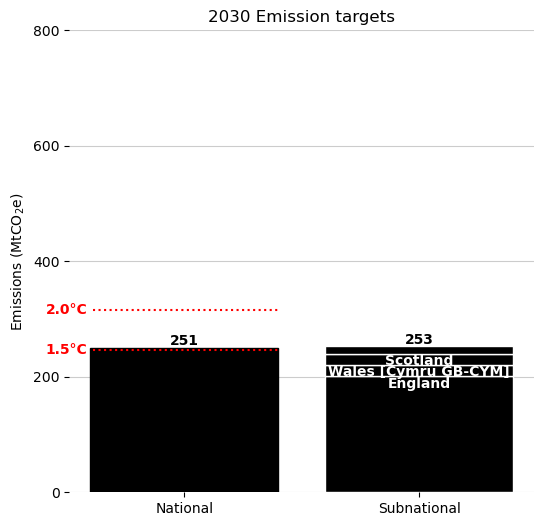

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

national = df_nat['target_emissions'].item()

ax.bar(0, national, bottom=0, label=actor_id, color = 'black', edgecolor = 'black')

# number of subnationals to display labels for
n_subnats = 3

y_offset = 20

previous = 0
for iterator, row in df_fin.iterrows():
    emissions = row['target_emissions']
    cumulative = row['cumulative']
    part_id = row['actor_id']
    actor_name = row['name']
    
    if iterator < n_subnats:
        ax.text(1, cumulative - y_offset, actor_name, ha='center', weight='bold', color='white')
    
    ax.bar(1, emissions, bottom=previous, label=part_id, color = 'black', edgecolor = 'white')
    
    previous = cumulative

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# grid and tick marks
y_max = math.ceil(cumulative / 1000) * 1000
y_diff = y_max / 5
ax.set_yticks(np.arange(0, y_max, y_diff))
ax.grid(axis='y',
        which='major',
        color=[0.8, 0.8, 0.8], linestyle='-')

ax.set_axisbelow(True)
ax.set_xticks([0, 1])
ax.set_xticklabels(['National', 'Subnational'])
ax.set_title("2030 Emission targets")
ax.set_ylabel("Emissions (MtCO$_2$e)")

ipcc = ipcc_range(df = df_emissions_nat, actor_id=actor_id)
paris_15 = ipcc['target_emissions_1.5C']/1_000_000
paris_20 = ipcc['target_emissions_2.0C']/1_000_000

y_middle = (paris_15 + paris_20) / 2

ax.axhline(y=paris_15, xmin=0.05, xmax=0.45, color='red', linestyle='dotted')
ax.axhline(y=paris_20, xmin=0.05, xmax=0.45, color='red', linestyle='dotted')

ax.annotate('1.5\u00B0C', xy=(-0.65, paris_15), xytext=(10, 0),
            textcoords='offset points', ha='left', va='center', color='red', weight='bold', annotation_clip=False)

ax.annotate('2.0\u00B0C', xy=(-0.65, paris_20), xytext=(10, 0),
            textcoords='offset points', ha='left', va='center', color='red', weight='bold', annotation_clip=False,)

y_offset = 4
ax.text(0, national + y_offset, round(national), ha='center', weight='bold')

total = df_fin['cumulative'].iloc[-1]
ax.text(1, total + y_offset, round(total), ha='center', weight='bold')